In [2]:
from functions import read_data
import pandas as pd
import os 

import seaborn as sns
import matplotlib.pyplot as plt
print(os.getcwd())

/Users/gabrielbenato/Desktop/Anaconda/Project-HotChocolate


In [5]:
BA_dataset = pd.read_csv("DATA/BeerAdvocate_ratings_part_0.csv")
BA_users = read_data.fetch_csv("DATA/BeerAdvocate/gz/BeerAdvocate.tar.gz","users")
RB_dataset = pd.read_csv("DATA/RateBeer_ratings_part_0.csv")
RB_users = read_data.fetch_csv("DATA/RateBeer/gz/RateBeer.tar.gz","users")
#The datasets requires some cleaning for matching with user data
BA_dataset["user_id"] = BA_dataset["user_id"].apply(lambda x : x.strip()) 
RB_dataset["username"] = RB_dataset["username"].apply(lambda x : x.strip()) 


#Unknown location for some users, some users have user_id duplicates either in the users.csv (in this case, no location is available) or in ratings.txt:
BA_users["location"] = BA_users["location"].fillna("Unknown")
RB_users["location"] = RB_users["location"].fillna("Unknown")
RB_users.drop_duplicates(subset="user_id",keep='last',ignore_index=False,inplace=True)


In [32]:
BA_df = BA_dataset.merge(BA_users[["user_id","location"]], how="left",left_on= "user_id",right_on="user_id")
beer_most_drinked_by_country_BA =BA_df[["location","beer_name","user_id","rating"]].groupby(by=["location","beer_name"]).agg({"user_id":"count","rating":"sum"}).reset_index()
style_most_drinked_by_country_BA =BA_df[["location","style","user_id","rating"]].groupby(by=["location","style"]).agg({"user_id":"count","rating":"sum"}).reset_index()

for number in range(1,17):
    temp_BA = pd.read_csv(f"DATA/BeerAdvocate_ratings_part_{number}.csv")
    #print(number)
    temp_BA["user_id"] = temp_BA["user_id"].apply(lambda x : x.strip()) ## @gab: je sais pas pourquoi ça marcge ici mais pas dans la fonction
    #print(len(temp_BA))
    temp_BA = temp_BA.merge(BA_users[["user_id","location"]], how="left",left_on= "user_id",right_on="user_id")

    temp_grouped_on_beer_BA = temp_BA[["location","beer_name","user_id","rating"]].groupby(by=["location","beer_name"]).agg({"user_id":"count","rating":"sum"}).reset_index()
    temp_grouped_on_style_BA = temp_BA[["location","style","user_id","rating"]].groupby(by=["location","style"]).agg({"user_id":"count","rating":"sum"}).reset_index()
    #print(temp_grouped_on_beer_BA["user_id"].sum())


    beer_most_drinked_by_country_BA = pd.concat([beer_most_drinked_by_country_BA, temp_grouped_on_beer_BA]).groupby(['location', 'beer_name']).sum().reset_index()
    style_most_drinked_by_country_BA =  pd.concat([style_most_drinked_by_country_BA, temp_grouped_on_style_BA]).groupby(['location', 'style']).sum().reset_index()


In [5]:
def beer_and_style_agg_by_country(RB, path_source = 'Data/'):
    '''
    RB           (boolean) : Decide if we work on the RateBeer or BeerAdvocate dataset
    path_source  (string)  : path to Data folder 
    '''
    
    #initialize the difference between RateBeer and beerAdvocate
    if RB:
        database = 'RateBeer'
        csv_number = 15
    else:
        database = 'BeerAdvocate'
        csv_number = 17

    user_dataset = read_data.fetch_csv(path_source + database + '/gz/'+ database + '.tar.gz',"users")
    beer_agg_country = pd.DataFrame([])
    style_agg_country = pd.DataFrame([])
    
    #itterate on all the csv
    for number in range(0,csv_number):
        temp = pd.read_csv(f"{path_source}{database}_ratings_part_{number}.csv")
        #merge users' location to review dataset
        temp = temp.merge(user_dataset[["user_id","location"]], how="left",left_on= "user_id",right_on="user_id")
        #group by beer name and country of user + count votes and sum ratings 
        temp_grouped_on_beer = temp[["location","beer_name","user_id","rating"]].groupby(by=["location","beer_name"]).agg({"user_id":"count","rating":"sum"}).reset_index()
        #group by style  and country of user + count votes and sum ratings 
        temp_grouped_on_style = temp[["location","style","user_id","rating"]].groupby(by=["location","style"]).agg({"user_id":"count","rating":"sum"}).reset_index()

        beer_agg_country = pd.concat([beer_agg_country, temp_grouped_on_beer]).groupby(['location', 'beer_name']).sum().reset_index()
        style_agg_country =  pd.concat([style_agg_country, temp_grouped_on_style]).groupby(['location', 'style']).sum().reset_index()
        display(beer_agg_country)

    return beer_agg_country, style_agg_country

In [7]:
bam = beer_and_style_agg_by_country(RB = True)

,location,beer_name,user_id,rating
0,Abkhazia,Dieu du Ciel Rigor Mortis Abt,1,5.0
1,Abkhazia,Le Temps dune Pinte Porter 2 Temps,1,4.8
2,Abkhazia,Unibroue Éphémère Apple,1,4.8
3,Afghanistan,Karlovačko Pivo,1,2.7
4,Afghanistan,Pacifico Clara,1,2.8
...,...,...,...,...
117603,Wales,Somersby Apple Cider,1,1.6
117604,Wales,Tiger Beer,1,1.3
117605,Wales,Tsingtao,1,1.2
117606,Wales,Whitewater Belfast Ale,1,3.2


,location,beer_name,user_id,rating
0,Abkhazia,Dieu du Ciel Rigor Mortis Abt,1,5.0
1,Abkhazia,Le Temps dune Pinte Porter 2 Temps,1,4.8
2,Abkhazia,Unibroue Éphémère Apple,1,4.8
3,Afghanistan,Karlovačko Pivo,1,2.7
4,Afghanistan,Pacifico Clara,1,2.8
...,...,...,...,...
225382,Wales,Vielanker Weizen,1,3.4
225383,Wales,Weihenstephaner Hefeweissbier Dunkel,1,2.6
225384,Wales,Weihenstephaner Original,1,4.5
225385,Wales,Whitewater Belfast Ale,1,3.2


,location,beer_name,user_id,rating
0,Abkhazia,Dieu du Ciel Rigor Mortis Abt,1,5.0
1,Abkhazia,Katzerer Hefeweizen,1,0.8
2,Abkhazia,Katzerer Lagerbier,1,0.5
3,Abkhazia,Le Temps dune Pinte Porter 2 Temps,1,4.8
4,Abkhazia,Unibroue Éphémère Apple,1,4.8
...,...,...,...,...
360481,Wales,Wrexham Lager,1,3.0
360482,Wales,Wrexham Lager Export,1,2.7
360483,Wales,Yo-Ho Tokyo Black Porter,1,2.5
360484,Zimbabwe,Rex Strong Beer,1,4.4


,location,beer_name,user_id,rating
0,Abkhazia,Dieu du Ciel Rigor Mortis Abt,1,5.0
1,Abkhazia,Katzerer Hefeweizen,1,0.8
2,Abkhazia,Katzerer Lagerbier,1,0.5
3,Abkhazia,Le Temps dune Pinte Porter 2 Temps,1,4.8
4,Abkhazia,Unibroue Éphémère Apple,1,4.8
...,...,...,...,...
502218,Wales,Zipfer Urtyp,1,2.6
502219,Zambia,Carling Black Label Beer (South Africa),1,5.0
502220,Zambia,La Trappe Witte Trappist,1,3.9
502221,Zimbabwe,Rex Strong Beer,1,4.4


,location,beer_name,user_id,rating
0,Abkhazia,Dieu du Ciel Rigor Mortis Abt,1,5.0
1,Abkhazia,Katzerer Hefeweizen,1,0.8
2,Abkhazia,Katzerer Lagerbier,1,0.5
3,Abkhazia,Le Temps dune Pinte Porter 2 Temps,1,4.8
4,Abkhazia,Unibroue Éphémère Apple,1,4.8
...,...,...,...,...
600936,Zambia,La Trappe Witte Trappist,1,3.9
600937,Zimbabwe,Atlas Super Strong 12%,1,4.7
600938,Zimbabwe,Rex Strong Beer,1,4.4
600939,Zimbabwe,Zambezi,1,3.0


,location,beer_name,user_id,rating
0,Abkhazia,Dieu du Ciel Rigor Mortis Abt,1,5.0
1,Abkhazia,Katzerer Hefeweizen,1,0.8
2,Abkhazia,Katzerer Lagerbier,1,0.5
3,Abkhazia,Le Temps dune Pinte Porter 2 Temps,1,4.8
4,Abkhazia,Unibroue Éphémère Apple,1,4.8
...,...,...,...,...
713663,Zambia,La Trappe Witte Trappist,1,3.9
713664,Zimbabwe,Atlas Super Strong 12%,1,4.7
713665,Zimbabwe,Rex Strong Beer,1,4.4
713666,Zimbabwe,Zambezi,1,3.0


,location,beer_name,user_id,rating
0,Abkhazia,Dieu du Ciel Rigor Mortis Abt,1,5.0
1,Abkhazia,Katzerer Hefeweizen,1,0.8
2,Abkhazia,Katzerer Lagerbier,1,0.5
3,Abkhazia,Le Temps dune Pinte Porter 2 Temps,1,4.8
4,Abkhazia,Unibroue Éphémère Apple,1,4.8
...,...,...,...,...
848399,Zambia,La Trappe Witte Trappist,1,3.9
848400,Zimbabwe,Atlas Super Strong 12%,1,4.7
848401,Zimbabwe,Rex Strong Beer,1,4.4
848402,Zimbabwe,Zambezi,1,3.0


,location,beer_name,user_id,rating
0,Abkhazia,Dieu du Ciel Rigor Mortis Abt,1,5.0
1,Abkhazia,Katzerer Hefeweizen,1,0.8
2,Abkhazia,Katzerer Lagerbier,1,0.5
3,Abkhazia,Le Temps dune Pinte Porter 2 Temps,1,4.8
4,Abkhazia,Unibroue Éphémère Apple,1,4.8
...,...,...,...,...
980259,Zambia,La Trappe Witte Trappist,1,3.9
980260,Zimbabwe,Atlas Super Strong 12%,1,4.7
980261,Zimbabwe,Rex Strong Beer,1,4.4
980262,Zimbabwe,Zambezi,1,3.0


,location,beer_name,user_id,rating
0,Abkhazia,Dieu du Ciel Rigor Mortis Abt,1,5.0
1,Abkhazia,Katzerer Hefeweizen,1,0.8
2,Abkhazia,Katzerer Lagerbier,1,0.5
3,Abkhazia,Le Temps dune Pinte Porter 2 Temps,1,4.8
4,Abkhazia,Michelob Ultra Dragon Fruit Peach,1,0.5
...,...,...,...,...
1142885,Zimbabwe,Atlas Super Strong 12%,1,4.7
1142886,Zimbabwe,Budweiser,1,1.4
1142887,Zimbabwe,Rex Strong Beer,1,4.4
1142888,Zimbabwe,Zambezi,1,3.0


,location,beer_name,user_id,rating
0,Abkhazia,Dieu du Ciel Rigor Mortis Abt,1,5.0
1,Abkhazia,Katzerer Hefeweizen,1,0.8
2,Abkhazia,Katzerer Lagerbier,1,0.5
3,Abkhazia,Le Temps dune Pinte Porter 2 Temps,1,4.8
4,Abkhazia,Michelob Ultra Dragon Fruit Peach,1,0.5
...,...,...,...,...
1317946,Zimbabwe,Atlas Super Strong 12%,1,4.7
1317947,Zimbabwe,Budweiser,1,1.4
1317948,Zimbabwe,Rex Strong Beer,1,4.4
1317949,Zimbabwe,Zambezi,1,3.0


,location,beer_name,user_id,rating
0,Abkhazia,Dieu du Ciel Rigor Mortis Abt,1,5.0
1,Abkhazia,Katzerer Hefeweizen,1,0.8
2,Abkhazia,Katzerer Lagerbier,1,0.5
3,Abkhazia,Le Temps dune Pinte Porter 2 Temps,1,4.8
4,Abkhazia,Michelob Ultra Dragon Fruit Peach,1,0.5
...,...,...,...,...
1465555,Zimbabwe,Budweiser,1,1.4
1465556,Zimbabwe,Full Sail Session Premium Lager,1,3.8
1465557,Zimbabwe,Rex Strong Beer,1,4.4
1465558,Zimbabwe,Zambezi,1,3.0


,location,beer_name,user_id,rating
0,Abkhazia,Dieu du Ciel Rigor Mortis Abt,1,5.0
1,Abkhazia,Katzerer Hefeweizen,1,0.8
2,Abkhazia,Katzerer Lagerbier,1,0.5
3,Abkhazia,Le Temps dune Pinte Porter 2 Temps,1,4.8
4,Abkhazia,Michelob Ultra Dragon Fruit Peach,1,0.5
...,...,...,...,...
1604089,Zimbabwe,Budweiser,1,1.4
1604090,Zimbabwe,Full Sail Session Premium Lager,1,3.8
1604091,Zimbabwe,Rex Strong Beer,1,4.4
1604092,Zimbabwe,Zambezi,1,3.0


,location,beer_name,user_id,rating
0,Abkhazia,Dieu du Ciel Rigor Mortis Abt,1,5.0
1,Abkhazia,Katzerer Hefeweizen,1,0.8
2,Abkhazia,Katzerer Lagerbier,1,0.5
3,Abkhazia,Le Temps dune Pinte Porter 2 Temps,1,4.8
4,Abkhazia,Michelob Ultra Dragon Fruit Peach,1,0.5
...,...,...,...,...
1719461,Zimbabwe,Budweiser,1,1.4
1719462,Zimbabwe,Full Sail Session Premium Lager,1,3.8
1719463,Zimbabwe,Rex Strong Beer,1,4.4
1719464,Zimbabwe,Zambezi,1,3.0


,location,beer_name,user_id,rating
0,Abkhazia,Dieu du Ciel Rigor Mortis Abt,1,5.0
1,Abkhazia,Katzerer Hefeweizen,1,0.8
2,Abkhazia,Katzerer Lagerbier,1,0.5
3,Abkhazia,Le Temps dune Pinte Porter 2 Temps,1,4.8
4,Abkhazia,Michelob Ultra Dragon Fruit Peach,1,0.5
...,...,...,...,...
1798103,Zimbabwe,Budweiser,1,1.4
1798104,Zimbabwe,Full Sail Session Premium Lager,1,3.8
1798105,Zimbabwe,Rex Strong Beer,1,4.4
1798106,Zimbabwe,Zambezi,1,3.0


,location,beer_name,user_id,rating
0,Abkhazia,Dieu du Ciel Rigor Mortis Abt,1,5.0
1,Abkhazia,Katzerer Hefeweizen,1,0.8
2,Abkhazia,Katzerer Lagerbier,1,0.5
3,Abkhazia,Le Temps dune Pinte Porter 2 Temps,1,4.8
4,Abkhazia,Michelob Ultra Dragon Fruit Peach,1,0.5
...,...,...,...,...
1836097,Zimbabwe,Budweiser,1,1.4
1836098,Zimbabwe,Full Sail Session Premium Lager,1,3.8
1836099,Zimbabwe,Rex Strong Beer,1,4.4
1836100,Zimbabwe,Zambezi,1,3.0


In [7]:
RB_dataset["username"] = RB_dataset["username"].apply(lambda x : x.strip()) 

RB_df = RB_dataset.merge(RB_users[["user_id","location"]], how="left",left_on= "user_id",right_on="user_id")
beer_most_drinked_by_country_RB =RB_df[["location","beer_name","user_id","rating"]].groupby(by=["location","beer_name"]).agg({"user_id":"count","rating":"sum"}).reset_index()
style_most_drinked_by_country_RB =RB_df[["location","style","user_id","rating"]].groupby(by=["location","style"]).agg({"user_id":"count","rating":"sum"}).reset_index()
def correct_double_user_id(row):
    name = row["username"].strip()
    return RB_users[RB_users["user_name"] == name]['location'].values[0]
for number in range(1,15):
    #print(number)
    temp_RB = pd.read_csv(f"DATA/RateBeer_ratings_part_{number}.csv")
    #print(len(temp_RB))
    RB_dataset["username"] = RB_dataset["username"].apply(lambda x : x.strip()) 
    
    temp_RB = temp_RB.merge(RB_users[["user_id","location"]], how="left",left_on= "user_id",right_on="user_id")
    double_id_rows = temp_RB[temp_RB["location"].isna()]
    if len(double_id_rows) != 0:
        temp_RB.loc[temp_RB["location"].isna(),"location"] = temp_RB.loc[temp_RB["location"].isna()].apply(lambda row : correct_double_user_id(row),axis=1).apply(str)
    
    temp_grouped_on_beer_RB = temp_RB[["location","beer_name","user_id","rating"]].groupby(by=["location","beer_name"]).agg({"user_id":"count","rating":"sum"}).reset_index()
    temp_grouped_on_style_RB = temp_RB[["location","style","user_id","rating"]].groupby(by=["location","style"]).agg({"user_id":"count","rating":"sum"}).reset_index()
    beer_most_drinked_by_country_RB = pd.concat([beer_most_drinked_by_country_RB, temp_grouped_on_beer_RB]).groupby(['location', 'beer_name']).sum().reset_index()
    style_most_drinked_by_country_RB = pd.concat([style_most_drinked_by_country_RB, temp_grouped_on_style_RB]).groupby(['location', 'style']).sum().reset_index()
    #print(temp_grouped_on_beer_RB["user_id"].sum())


In [8]:

#We renormalize the averages that were aggregated from all parts of the dataset
beer_most_drinked_by_country_BA["normalized_rating"] = beer_most_drinked_by_country_BA.apply(lambda row: row["rating"]/row["user_id"],axis=1)
style_most_drinked_by_country_BA["normalized_rating"] = style_most_drinked_by_country_BA.apply(lambda row: row["rating"]/row["user_id"],axis=1)

beer_most_drinked_by_country_RB["normalized_rating"] = beer_most_drinked_by_country_RB.apply(lambda row: row["rating"]/row["user_id"],axis=1)
style_most_drinked_by_country_RB["normalized_rating"] = style_most_drinked_by_country_RB.apply(lambda row: row["rating"]/row["user_id"],axis=1)

#Sanity check : 
# For BeerAdvocate, we have 16 csvs with 500'000 ratings and 1 csv with 393'032 ratings. 
#We should have 8'393'032 in total.
print(beer_most_drinked_by_country_BA["user_id"].sum())
#Sanity check : 
# For Ratebeer, we have 14 csvs with 500'000 ratings and 1 csv with 122'074 ratings. 
#We should have 7'122'074 in total.
print(beer_most_drinked_by_country_RB["user_id"].sum())


8393032
7122074


,location,beer_name,count,cumulated_rating,normalized_rating
0,Abkhazia,Dieu du Ciel Rigor Mortis Abt,1,5.0,5.0
1,Abkhazia,Katzerer Hefeweizen,1,0.8,0.8
2,Abkhazia,Katzerer Lagerbier,1,0.5,0.5
3,Abkhazia,Le Temps dune Pinte Porter 2 Temps,1,4.8,4.8
4,Abkhazia,Michelob Ultra Dragon Fruit Peach,1,0.5,0.5
...,...,...,...,...,...
1895582,Zimbabwe,Budweiser,1,1.4,1.4
1895583,Zimbabwe,Full Sail Session Premium Lager,1,3.8,3.8
1895584,Zimbabwe,Rex Strong Beer,1,4.4,4.4
1895585,Zimbabwe,Zambezi,1,3.0,3.0


,location,beer_name,count,cumulated_rating,normalized_rating
0,Afghanistan,Bigfoot Barleywine-Style Ale,1,4.12,4.12
1,Afghanistan,Carlton Draught,1,2.00,2.00
2,Afghanistan,Eliksir,1,4.75,4.75
3,Afghanistan,Guinness Draught,1,2.50,2.50
4,Afghanistan,Heineken Lager Beer,1,1.00,1.00
...,...,...,...,...,...
1272771,Wales,Yeti Imperial Stout,1,4.82,4.82
1272772,Wales,Young's Waggledance Honey Ale,1,3.25,3.25
1272773,Wales,Zirndorfer Landweizen,1,2.92,2.92
1272774,Wales,[BANISHED] Tough Love,1,4.78,4.78


,location,style,count,cumulated_rating,normalized_rating
0,Abkhazia,Abt/Quadrupel,1,5.0,5.00
1,Abkhazia,Fruit Beer,2,5.3,2.65
2,Abkhazia,German Hefeweizen,1,0.8,0.80
3,Abkhazia,Porter,1,4.8,4.80
4,Abkhazia,Zwickel/Keller/Landbier,1,0.5,0.50
...,...,...,...,...,...
10976,Zambia,Pale Lager,1,5.0,5.00
10977,Zambia,Witbier,1,3.9,3.90
10978,Zimbabwe,Malt Liquor,2,9.1,4.55
10979,Zimbabwe,Pale Lager,3,6.6,2.20


,location,style,count,cumulated_rating,normalized_rating
0,Afghanistan,American Adjunct Lager,1,2.00,2.00000
1,Afghanistan,American Barleywine,1,4.12,4.12000
2,Afghanistan,American Porter,1,3.51,3.51000
3,Afghanistan,Belgian Strong Dark Ale,1,4.92,4.92000
4,Afghanistan,Czech Pilsener,1,1.50,1.50000
...,...,...,...,...,...
12216,Wales,Vienna Lager,2,8.06,4.03000
12217,Wales,Weizenbock,2,4.69,2.34500
12218,Wales,Winter Warmer,3,11.85,3.95000
12219,Wales,Witbier,8,30.35,3.79375


[0          1
 1          1
 2          1
 3          1
 4          1
           ..
 1895582    1
 1895583    1
 1895584    1
 1895585    1
 1895586    1
 Name: count, Length: 1895587, dtype: int64,
 0          1
 1          1
 2          1
 3          1
 4          1
           ..
 1272771    1
 1272772    1
 1272773    1
 1272774    1
 1272775    1
 Name: count, Length: 1272776, dtype: int64,
 0        1
 1        2
 2        1
 3        1
 4        1
         ..
 10976    1
 10977    1
 10978    2
 10979    3
 10980    1
 Name: count, Length: 10981, dtype: int64,
 0        1
 1        1
 2        1
 3        1
 4        1
         ..
 12216    2
 12217    2
 12218    3
 12219    8
 12220    1
 Name: count, Length: 12221, dtype: int64]

In plot 0 the quantile 0.25 is 1.0
In plot 0 the quantile 0.5 is 1.0
In plot 0 the quantile 0.75 is 3.0
In plot 1 the quantile 0.25 is 1.0
In plot 1 the quantile 0.5 is 1.0
In plot 1 the quantile 0.75 is 4.0
In plot 2 the quantile 0.25 is 10.0
In plot 2 the quantile 0.5 is 72.0
In plot 2 the quantile 0.75 is 434.0
In plot 3 the quantile 0.25 is 5.0
In plot 3 the quantile 0.5 is 39.0
In plot 3 the quantile 0.75 is 305.0


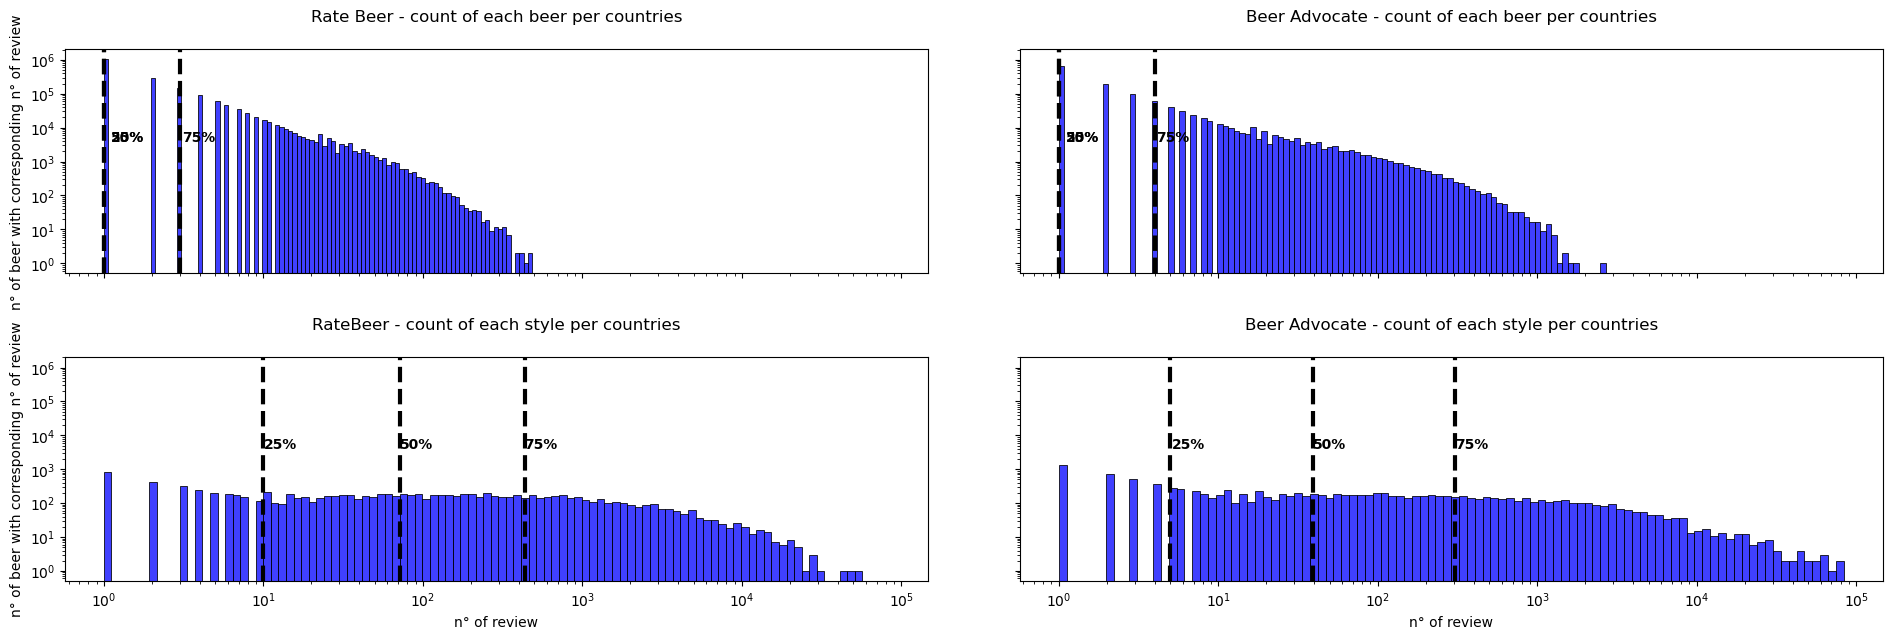

In [24]:
#Standardize column names before saving work
BEER_COLUMN_NAMES = ["location","beer_name","count","cumulated_rating","normalized_rating"]
STYLE_COLUMN_NAMES = ["location","style","count","cumulated_rating","normalized_rating"]
beer_most_drinked_by_country_RB.columns = BEER_COLUMN_NAMES
beer_most_drinked_by_country_BA.columns = BEER_COLUMN_NAMES
style_most_drinked_by_country_RB.columns = STYLE_COLUMN_NAMES
style_most_drinked_by_country_BA.columns = STYLE_COLUMN_NAMES
display(beer_most_drinked_by_country_RB)
display(beer_most_drinked_by_country_BA)
display(style_most_drinked_by_country_RB)
display(style_most_drinked_by_country_BA)

quantiles = [0.25, 0.5, 0.75]

titles = ['Rate Beer - count of each beer per countries',
          'Beer Advocate - count of each beer per countries',
          'RateBeer - count of each style per countries',
          'Beer Advocate - count of each style per countries']

plot_data = [beer_most_drinked_by_country_RB['count'],
             beer_most_drinked_by_country_BA['count'],
             style_most_drinked_by_country_RB['count'],
             style_most_drinked_by_country_BA['count']]
display(plot_data)
fig, axes = plt.subplots(2, 2, figsize=(20, 7),sharey=True,sharex=True)
fig.tight_layout(pad=5)
for i,datum in enumerate(plot_data):
    sns.histplot(ax=axes.flat[i],data=datum,bins=100,log_scale=(True,True), kde=False, color="blue")
    axes.flat[i].set_ylabel("n° of beer with corresponding n° of review")
    axes.flat[i].set_xlabel("n° of review")
    axes.flat[i].set_title(titles[i], pad=20)
    for q in quantiles:
        axes.flat[i].axvline(plot_data[i].quantile(q), 0, 1, color="black", ls='--',linewidth=3)
        print(f'In plot {i} the quantile {q} is {plot_data[i].quantile(q)}')
        axes.flat[i].text(plot_data[i].quantile(q)+0.1, 4e3, str(int(q*100))+'%', horizontalalignment='left', size='medium', color='black', weight='semibold')


# Cut-off
We choose 3, and 5 review for the cut-off of beers and style respectivly due to the distribution of the n° of reviews 

In [21]:
def most_rated(df):
    df = df.reset_index()
    row = df.iloc[df['count'].idxmax()].copy()
    return row
def best_rating(df,threshold,metric):
    df = df.reset_index()
    row = df.loc[[0]].copy()
    df = df[df["count"] > threshold].copy()
    if len(df) == 0:
        row[metric] = "No beer with enough votes"
        return row
    else : 
        row = df.loc[[df['normalized_rating'].idxmax()]].copy()
        return row
most_reviewed_beer_BA = beer_most_drinked_by_country_BA.groupby(by="location").apply(lambda df : most_rated(df)).reset_index(drop=True)
most_reviewed_beer_RB = beer_most_drinked_by_country_RB.groupby(by="location").apply(lambda df : most_rated(df)).reset_index(drop=True)
favorite_beer_BA = beer_most_drinked_by_country_BA.groupby(by="location").apply(lambda df : best_rating(df,3,"beer_name")).reset_index(drop=True)
favorite_beer_RB = beer_most_drinked_by_country_RB.groupby(by="location").apply(lambda df : best_rating(df,3,"beer_name")).reset_index(drop=True)

most_reviewed_style_BA = style_most_drinked_by_country_BA.groupby(by="location").apply(lambda df : most_rated(df)).reset_index(drop=True)
most_reviewed_style_RB = style_most_drinked_by_country_RB.groupby(by="location").apply(lambda df : most_rated(df)).reset_index(drop=True)
favorite_style_BA = style_most_drinked_by_country_BA.groupby(by="location").apply(lambda df : best_rating(df,5,"style")).reset_index(drop=True)
favorite_style_RB = style_most_drinked_by_country_RB.groupby(by="location").apply(lambda df : best_rating(df,5,"style")).reset_index(drop=True)

In [22]:
#Save work
#display(style_most_drinked_by_country_BA)
display(favorite_style_BA)
most_reviewed_beer_BA.to_csv("DATA/most_reviewed_beer_BA.csv",index=True)
most_reviewed_beer_RB.to_csv("DATA/most_reviewed_beer_RB.csv",index=True)
most_reviewed_style_BA.to_csv("DATA/most_reviewed_style_BA.csv",index=True)
most_reviewed_style_RB.to_csv("DATA/most_reviewed_style_RB.csv",index=True)
favorite_beer_RB.to_csv("DATA/favourite_beer_RB.csv",index=True)
favorite_beer_BA.to_csv("DATA/favourite_beer_BA.csv",index=True)
favorite_style_RB.to_csv("DATA/favourite_style_RB.csv",index=True)
favorite_style_BA.to_csv("DATA/favourite_style_BA.csv",index=True)

,index,location,style,count,cumulated_rating,normalized_rating
0,0,Afghanistan,No beer with enough votes,1,2.00,2.000000
1,11,Albania,No beer with enough votes,1,3.75,3.750000
2,15,American Samoa,No beer with enough votes,2,7.89,3.945000
3,32,Andorra,No beer with enough votes,1,5.00,5.000000
4,37,Angola,No beer with enough votes,1,3.69,3.690000
...,...,...,...,...,...,...
190,12010,Vanuatu,No beer with enough votes,1,1.70,1.700000
191,12022,Venezuela,American Double / Imperial Stout,33,147.99,4.484545
192,12129,Vietnam,Hefeweizen,11,42.18,3.834545
193,12154,Wales,American Double / Imperial IPA,11,45.78,4.161818
